# Overview

This is the forth notebook of the project.

In this notebook, we will load 200 labeled MNIST samples to validate what we concluded in the last notebook regarding data efficiency.

# Load data

In this notebook we will load only 200 labeled data to make sure there is no data leak (see more training data) in the process.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# We only load the 200 sample data set for training
raw_train_df = pd.read_csv("/kaggle/input/mnist/mnist_200.csv")
raw_test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

X_train = raw_train_df.values[:, 1:]
y_train = raw_train_df.values[:, 0]
print('X_train shape:', X_train.shape)

X_test = raw_test_df.values
print('X_test shape:', X_test.shape)

X_all = np.concatenate((X_train, X_test), axis=0)
print('X_all shape:', X_all.shape)

# unsupervised learning model

As the result of previous analysis, we will use T-SNE 2D + GaussianMixture to perform unsupervised learning.

In [ ]:
%%time

from sklearn.manifold import TSNE

# For unsupervised learning, we always use the full data set for clustering, so we just need to do tsne once.
# Helper function for evaluate the best accuracy using tsne + kmeans

tsne_2d = TSNE(n_components=2, random_state=99).fit_transform(X_all)

In [ ]:
from scipy.stats import mode
from sklearn.mixture import GaussianMixture

# Helper function to get a map from cluster id to real label
# We utilize the true label to inffer the mapping
def cluster_id_2_label(cluster_ids, y_true):
    cluster_2_label = {}
    for i in np.unique(cluster_ids):
        #print('cluster id:', i)
        mask = (cluster_ids == i)
        y_mode = mode(y_true[mask])[0][0]
        cluster_2_label[i] = y_mode if y_mode is not None else -1

    return cluster_2_label

# helper class for evaluating gausian mixture
def evl_gm(X_train, y_train, X_test):
    best_train_score = 0
    best_n_components = 0
    best_y_test_predict = None
    for n_components in range(10, 40, 2):
        cluster_ids = GaussianMixture(n_components, random_state=0).fit_predict(tsne_2d)
        cluster_id_map = cluster_id_2_label(cluster_ids[:y_train.shape[0]], y_train)
        try:
            # when the train size is too small and n_componetns is large, it can happen that there is no mapping found
            y_all_predict = np.vectorize(cluster_id_map.get)(cluster_ids)
        except:
            continue
        score = accuracy_score(y_train, y_all_predict[:y_train.shape[0]])
        print('n_components:', n_components, 'train score:', score)
        if score > best_train_score:
            best_train_score = score
            best_n_components = n_components
            best_y_test_predict = y_all_predict[y_train.shape[0]:]

    print('best n_components:', best_n_components, 'best gm score:', best_train_score)
    
    return best_y_test_predict

y_test_predict = evl_gm(X_train, y_train, X_test)

In [ ]:
test_result = pd.DataFrame(columns=['ImageId', 'Label'])
test_result['ImageId'] = range(1, y_test_predict.shape[0]+1)
test_result['Label'] =  y_test_predict

test_result.to_csv('submission_semi_200.csv', index=False)

### Observations

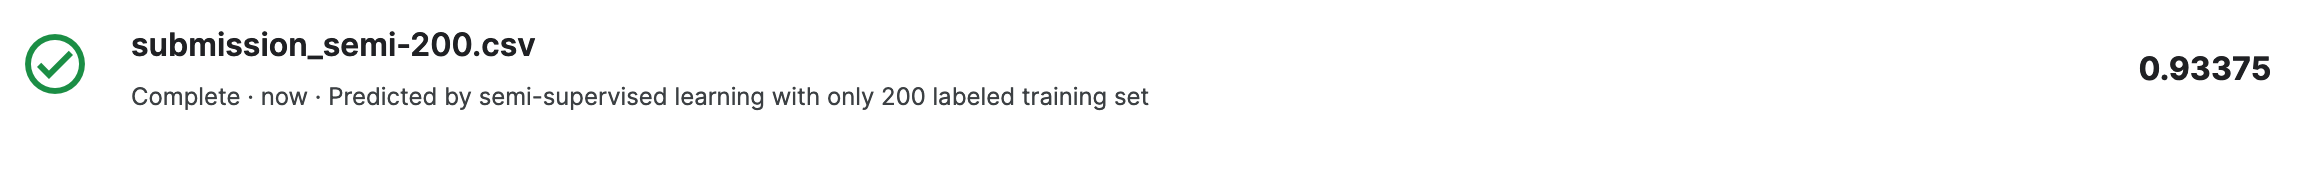

1. After submission, we got a accuracy of 93.4%. 
2. It is a bit less than expected  value of 96%, I think it is because we have less unlabeled data. The previous test there is 42k samples, while here we only have 28k. 
3. For unsupervised learning, the more data (doesn't matter labeled or not) the better the result.

# Supervised learning

For comparison, we still use KNN as supervised learning model. The same 200 labeled samples would be splitted for training and parameter selection. And the final model would use all the 200 samples for training.


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Helper function for evaluate the best accuracy using knn
def evl_knn(X_train, y_train, X_test):
    # split the train set to 80/20
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    best_validation_score = 0
    best_k = 0
    for k in range(1, 5):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_valid_pred = knn.predict(X_valid)
        score = accuracy_score(y_valid, y_valid_pred)
        print('k:', k, ', validation score:', score)
        if score > best_validation_score:
            best_validation_score = score
            best_k = k
    print('best k:', best_k, 'best_valid_score:', best_validation_score)
    
    # Calculate test score
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(X_train, y_train)
    return knn.predict(X_test)

In [ ]:
y_test_predict_knn = evl_knn(X_train, y_train, X_test)
print(y_test_predict_knn.shape)

test_result_knn = pd.DataFrame(columns=['ImageId', 'Label'])
test_result_knn['ImageId'] = range(1, y_test_predict_knn.shape[0]+1)
test_result_knn['Label'] =  y_test_predict_knn

test_result_knn.to_csv('submission_knn_200.csv', index=False)

### Observations

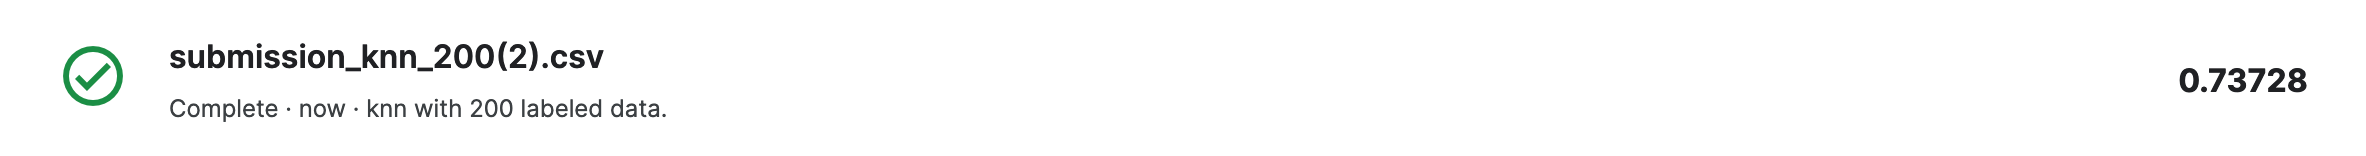

1. The submission of the result from knn has accuracy of 73.7% as expected. 
2. For supervised learning, the performance does not dependent on the size of test data, but only on the size of training data.
3. The unspervised learning has a result of 0.93, which is a bit less than we'd expected.
4. I assume the reason is we have less test data (28k) than the data (42k) we used in drawing the conclusion.
5. For unsupervised learning, the size of unlabeled data is important too.


# Discussion

Even though in this case with limited training data unsupervised learning have a supperisingly good performance, this can not be generalised to all the cases. 

It works well in this case because:
1. The clusters are relatives well separated at the edges, if they would overlap with each other, the performance would not be that good
2. The shapes of the clusters are relatively regular, so that clustering algrithms works well
3. The number of categories are limit, so that a small number of samples can represent enough data in each category.
4. The number of samples in each category are well balanced, other wise the categories with smaller samples would not be well represented.

Without the above assumptions, we would need to use other methods to fix the issues, and the performance also might not be that good.